# Binoculars

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow
import trieste

tfd = tfp.distributions
dtype = tf.float64

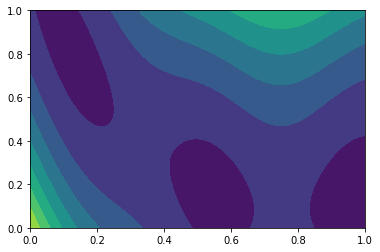

In [407]:
x_plot = tf.meshgrid(tf.linspace(0., 1., 100), tf.linspace(0., 1., 100))
x_plot = tf.stack(x_plot, axis=-1)
x_plot = tf.cast(x_plot, dtype=dtype)

y_plot = trieste.objectives.single_objectives.scaled_branin(x_plot)
y_plot = tf.cast(y_plot, dtype=dtype)

plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], y_plot[:, :, 0])
plt.show()

In [408]:
x = tf.cast(tf.random.uniform([5, 2]), dtype=dtype)
y = tf.cast(trieste.objectives.single_objectives.scaled_branin(x), dtype=dtype)
print(tf.reduce_min(y), tf.reduce_max(y))

tf.Tensor(-0.9927852288430425, shape=(), dtype=float64) tf.Tensor(0.5075163152273717, shape=(), dtype=float64)


In [409]:
kernel = gpflow.kernels.Matern32()
gp = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
optimiser = gpflow.optimizers.Scipy()
result = optimiser.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=10000))

In [410]:
mean_plot, var_plot = gp.predict_f(x_plot)

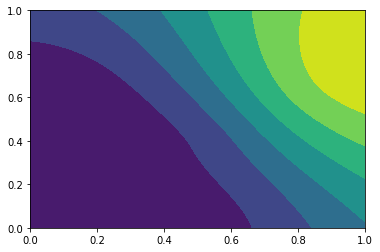

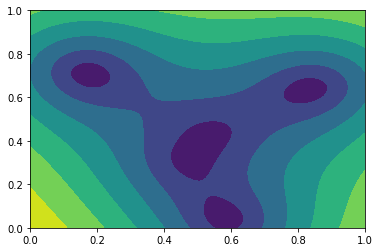

In [411]:
plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], mean_plot[:, :, 0])
plt.show()

plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], var_plot[:, :, 0]**0.5)
plt.show()

In [412]:
# Define GP model
# Define objective function

# Sample initial points
#   Search domain

# Until done:
#   Initialise batch
#   Optimise batch locations
#   Select expected improvements

In [636]:
def joint_expected_improvement(
        mean: tf.Tensor,
        covariance: tf.Tensor,
        threshold: tf.Tensor,
        num_samples: int,
        diagonal: bool = False,
    ):
    
    distribution = tfd.MultivariateNormalFullCovariance(
        loc=mean,
        covariance_matrix=covariance,
    )
    
    samples = distribution.sample(sample_shape=(num_samples,), seed=0)
    samples_min = tf.reduce_min(samples, axis=1)
    threshold = tf.repeat(threshold, num_samples)
    
    minimum = tf.reduce_min([samples_min, threshold], axis=0)
    
    return tf.reduce_mean(minimum - threshold)
    
    
def pointwise_expected_improvement(
        mean: tf.Tensor,
        variance: tf.Tensor,
        threshold: tf.Tensor,
        num_samples: int,
    ):
    
    distribution = tfd.Normal(loc=mean, scale=variance**0.5)
    
    samples = distribution.sample(sample_shape=(num_samples,), seed=0)
    threshold = threshold * tf.ones_like(samples)
    
    minimum = tf.reduce_min([samples, threshold], axis=0)
    return tf.reduce_mean(minimum - threshold, axis=0)


def compute_optimal_batch(
        gp,
        x_min: tf.Tensor,
        x_max: tf.Tensor,
        num_points: int,
        num_ei_samples: int,
        num_steps: int,
        learn_rate: float,
        print_every: int = None,
    ):
            
    @tf.function(jit_compile=True)
    def single_step(
            gp,
            batch_x: tf.Tensor,
            threshold: tf.Tensor,
            num_samples: int,
            optimiser: tf.optimizers.Optimizer
        ):

        with tf.GradientTape() as tape:

            tape.watch(batch_x)

            batch_mean, batch_cov = gp.predict_f(batch_x, full_cov=True)

            loss = joint_expected_improvement(
                mean=batch_mean[:, 0],
                covariance=batch_cov[0, :, :],
                threshold=threshold,
                num_samples=num_ei_samples,
            )

        gradients = tape.gradient(loss, [batch_x])
        optimiser.apply_gradients(zip(gradients, [batch_x]))

        batch_x.assign(tf.clip_by_value(batch_x, x_min, x_max))

        return loss
    
    dim = x_min.shape[0]
    dtype = x_min.dtype
    
    u = tf.random.uniform([num_points, dim], dtype=dtype)
    batch_x = tf.Variable(u * x_min[None, :] + (1 - u) * x_max[None, :])
    
    optimiser = tf.optimizers.Adam(lr=learn_rate)
    threshold = tf.reduce_min(gp.predict_f(gp.data[0]))
    
    losses = []
    
    for i in tf.range(num_steps):
        
        loss = single_step(
            gp=gp,
            batch_x=batch_x,
            threshold=threshold,
            num_samples=num_samples,
            optimiser=optimiser,
        )
        
        if print_every and i % print_every == 0:
            tf.print(loss)
            
        losses.append(loss)
            
    return batch_x, losses, threshold


def get_query_point(
        gp,
        batch_x: tf.Tensor,
        mode: str,
        temperature: float = None,
    ):

    batch_mean, batch_var = gp.predict_f(batch_x)
    
    threshold = tf.reduce_min(gp.predict_f(gp.data[0]))

    pointwise_ei = pointwise_expected_improvement(
        mean=batch_mean[:, 0],
        variance=batch_var[:, 0],
        threshold=threshold,
        num_samples=num_ei_samples,
    )
    
    if mode == "best":
        i = tf.argmin(pwei)
    
    elif mode == "random":
        i = tf.argmin(tf.random.uniform([batch_x.shape[0]]))
    
    elif mode == "tempered":
        
        logits = - tf.reshape(pointwise_ei, (1, -1))
        logit_range = tf.reduce_max(logits) - tf.reduce_min(logits)
        
        logits = logits / logit_range
        
        i = tf.random.categorical(
            logits=logits/temperature,
            num_samples=1
        )[0, 0]
        
        print(i, batch_x.shape, logits.shape)
    
    else:
        raise ValueError(f"Bad mode {mode}.")
        
    return batch_x[i], pointwise_ei


tf.random.set_seed(1)

x_min = tf.convert_to_tensor([0., 0.], dtype=dtype)
x_max = tf.convert_to_tensor([1., 1.], dtype=dtype)

num_points = 20
num_ei_samples = 150
num_steps = 1000
learn_rate = 1e-3
mode = "tempered"
    
batch_x, _, threshold = compute_optimal_batch(
    gp=gp,
    x_min=x_min,
    x_max=x_max,
    num_points=num_points,
    num_ei_samples=num_ei_samples,
    num_steps=num_steps,
    learn_rate=learn_rate,
)

KeyboardInterrupt: 

In [ ]:
batch_mean, batch_var = gp.predict_f(batch_x)

next_x, _ = get_query_point(
    gp=gp,
    batch_x=batch_x,
    mode=mode,
    temperature=1.,
)

In [ ]:
plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], y_plot[:, :, 0])
plt.scatter(x[:, 0], x[:, 1], color="red")
plt.scatter(batch_x[:, 0], batch_x[:, 1], color="green")
plt.scatter(next_x[0], next_x[1], color="orange")
plt.show()

tf.Tensor(10, shape=(), dtype=int64) (20, 2) (1, 20)


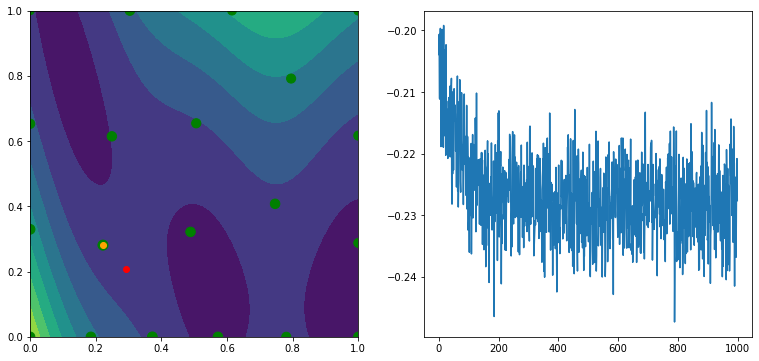

tf.Tensor(2, shape=(), dtype=int64) (19, 2) (1, 19)


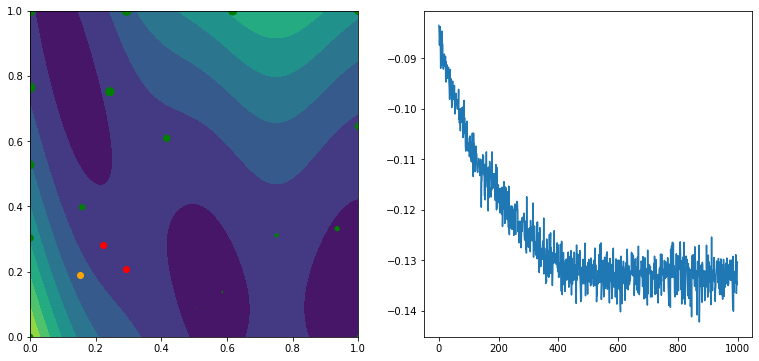

tf.Tensor(6, shape=(), dtype=int64) (18, 2) (1, 18)


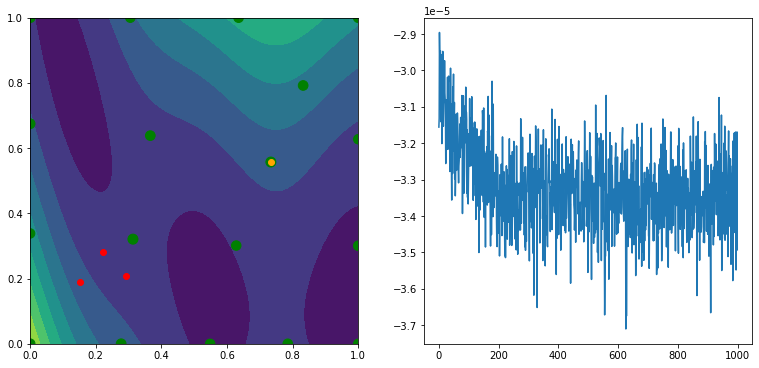

tf.Tensor(4, shape=(), dtype=int64) (17, 2) (1, 17)


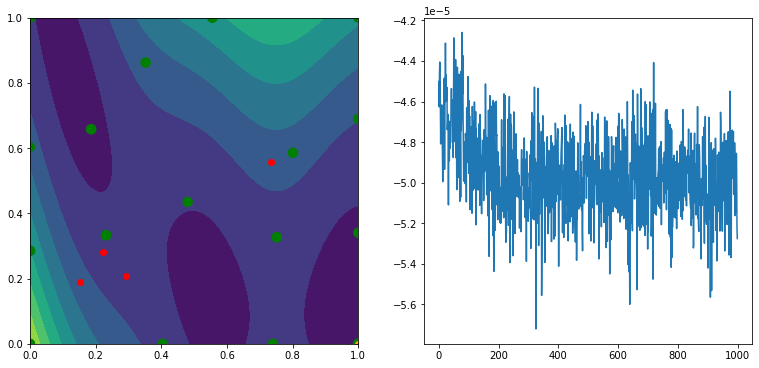

tf.Tensor(11, shape=(), dtype=int64) (16, 2) (1, 16)


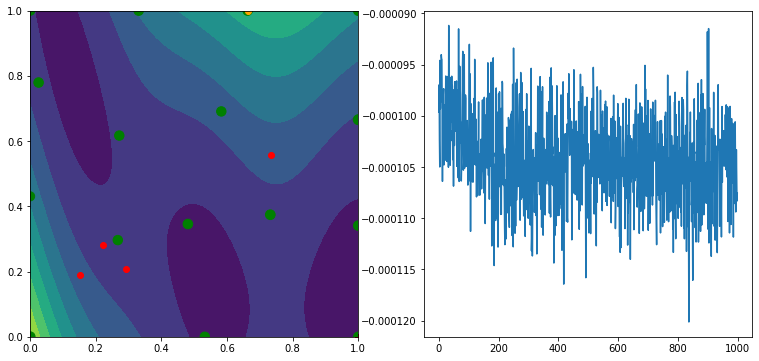

tf.Tensor(1, shape=(), dtype=int64) (15, 2) (1, 15)


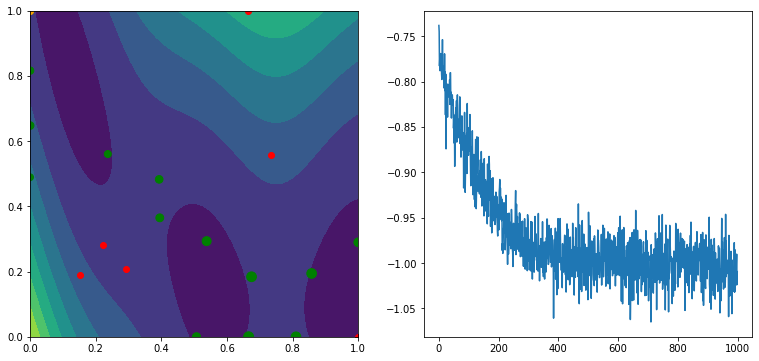

tf.Tensor(3, shape=(), dtype=int64) (14, 2) (1, 14)


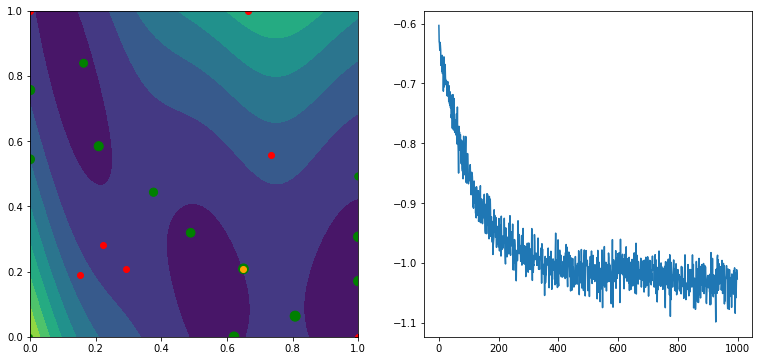

tf.Tensor(4, shape=(), dtype=int64) (13, 2) (1, 13)


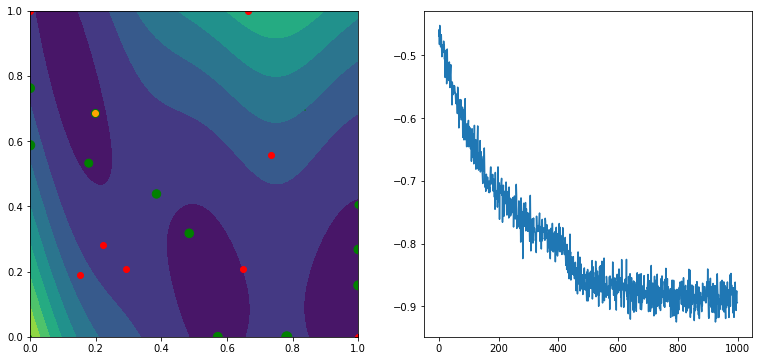

tf.Tensor(8, shape=(), dtype=int64) (12, 2) (1, 12)


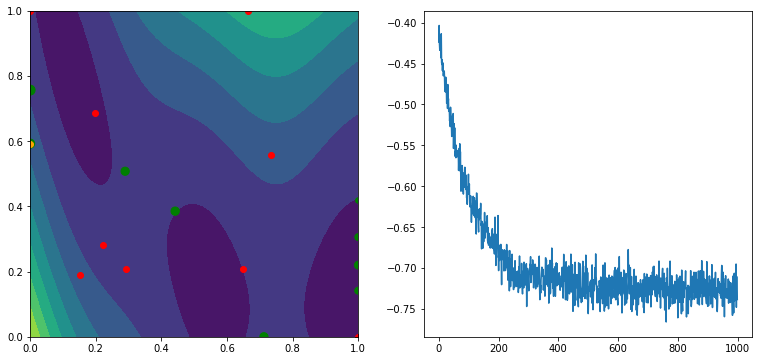

tf.Tensor(7, shape=(), dtype=int64) (11, 2) (1, 11)


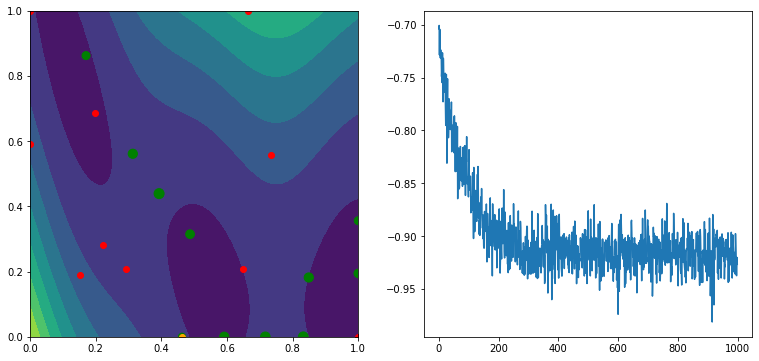

tf.Tensor(4, shape=(), dtype=int64) (10, 2) (1, 10)


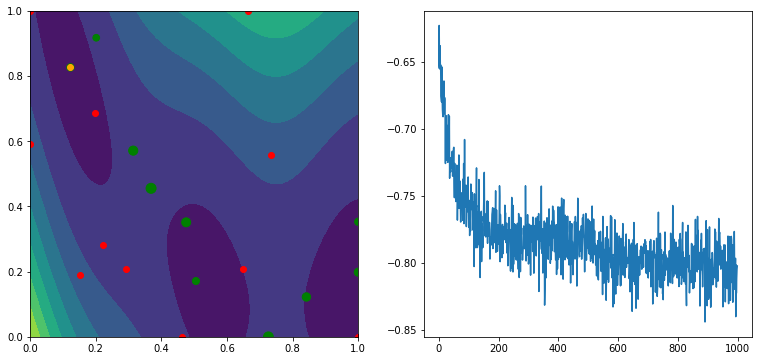

tf.Tensor(8, shape=(), dtype=int64) (9, 2) (1, 9)


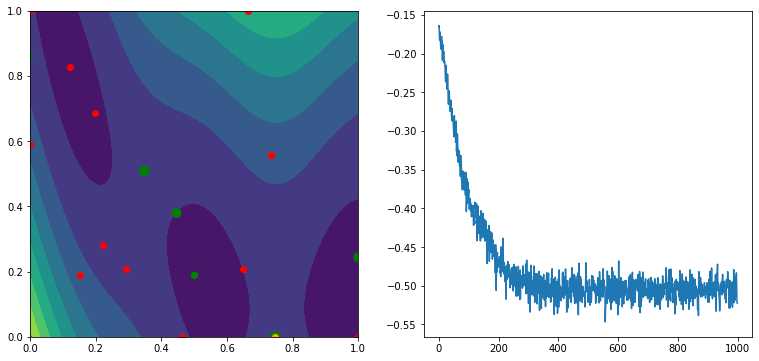

tf.Tensor(1, shape=(), dtype=int64) (8, 2) (1, 8)


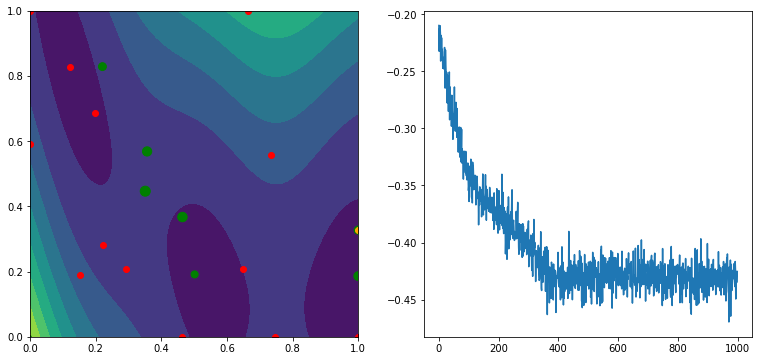

tf.Tensor(4, shape=(), dtype=int64) (7, 2) (1, 7)


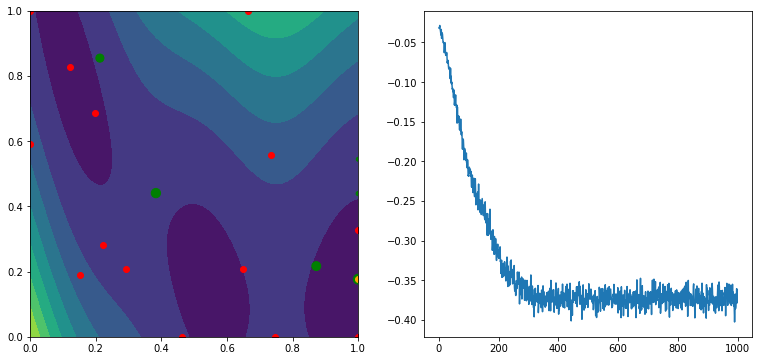

tf.Tensor(5, shape=(), dtype=int64) (6, 2) (1, 6)


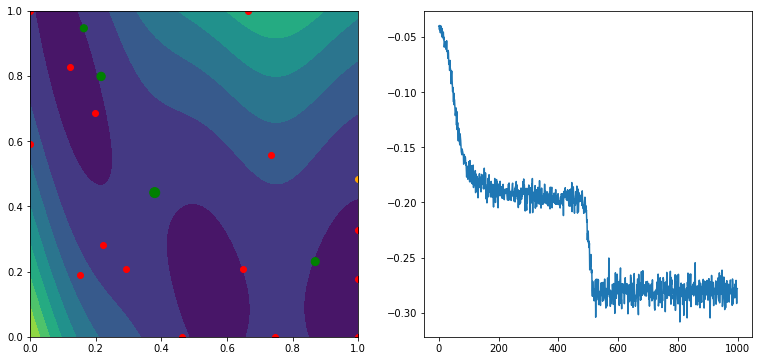

tf.Tensor(2, shape=(), dtype=int64) (5, 2) (1, 5)


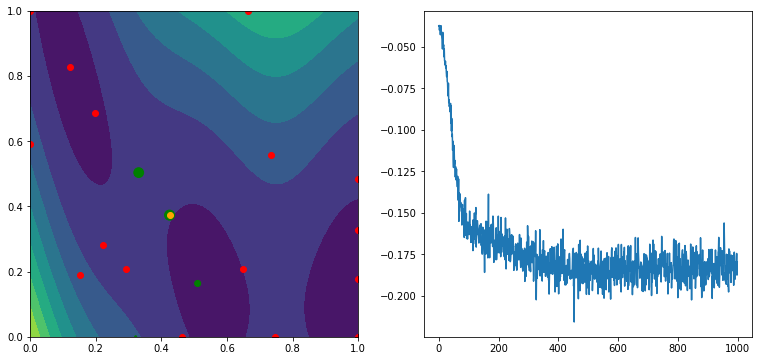

tf.Tensor(2, shape=(), dtype=int64) (4, 2) (1, 4)


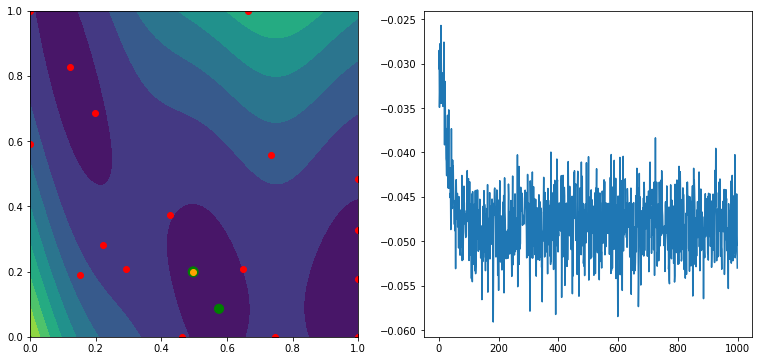

tf.Tensor(1, shape=(), dtype=int64) (3, 2) (1, 3)


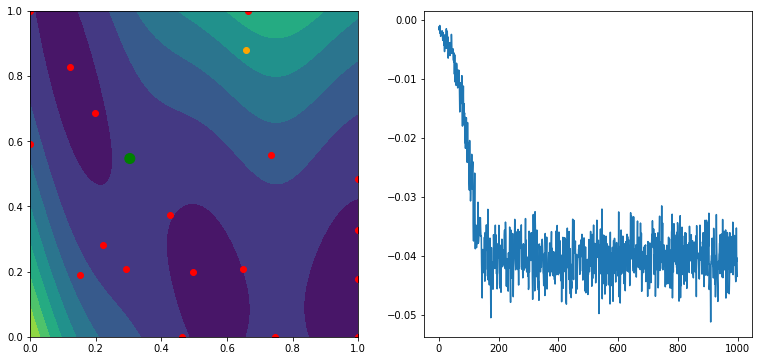

tf.Tensor(0, shape=(), dtype=int64) (2, 2) (1, 2)


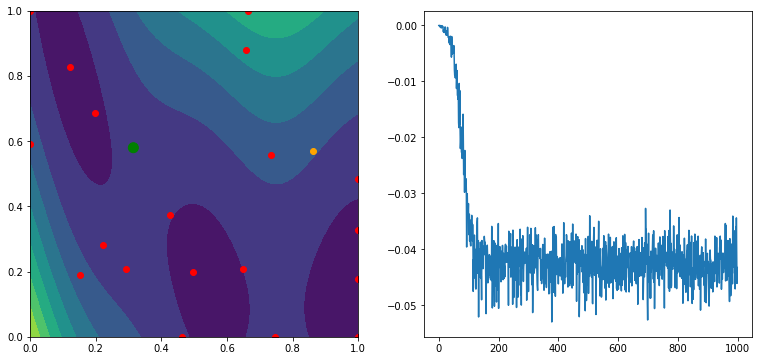

tf.Tensor(1, shape=(), dtype=int64) (1, 2) (1, 1)


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [635]:
tf.random.set_seed(0)

objective = trieste.objectives.single_objectives.scaled_branin
f = lambda x: tf.cast(objective(x), dtype=dtype)
num_queries = 20

num_initial = 1
num_ei_samples = 1000
num_steps = 1000
learn_rate = 1e-3
mode = "tempered"
temperature = 1.

x_data = tf.cast(
    tf.random.uniform([num_initial, 2]), 
    dtype=dtype
)

y_data = tf.cast(
    trieste.objectives.single_objectives.scaled_branin(x_data),
    dtype=dtype
)

for i in range(num_queries):
    
    batch_size = num_queries - i
    
    kernel = gpflow.kernels.Matern32()
    
    gp = gpflow.models.GPR(
        data=(x_data, y_data),
        kernel=kernel,
        mean_function=None
    )
    
    optimiser = gpflow.optimizers.Scipy()
    
    result = optimiser.minimize(
        gp.training_loss,
        gp.trainable_variables,
        options=dict(maxiter=10000)
    )
    
    batch_x, losses, threshold = compute_optimal_batch(
        gp=gp,
        x_min=x_min,
        x_max=x_max,
        num_points=batch_size,
        num_ei_samples=num_ei_samples,
        num_steps=num_steps,
        learn_rate=learn_rate,
    )
    
    next_x, pointwise_ei = get_query_point(
        gp=gp,
        batch_x=batch_x,
        mode=mode,
        temperature=temperature,
    )
    
    next_y = f(next_x)
    
    plt.figure(figsize=(20, 6))
    
    marker_size = 100*tf.abs(pointwise_ei)/tf.reduce_max(tf.abs(pointwise_ei))
    
    plt.subplot(1, 3, 1)
    plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], y_plot[:, :, 0])
    plt.scatter(x_data[:, 0], x_data[:, 1], color="red")
    plt.scatter(batch_x[:, 0], batch_x[:, 1], s=marker_size, color="green")
    plt.scatter(next_x[0], next_x[1], color="orange")
    
    plt.subplot(1, 3, 2)
    plt.plot(losses)
    
    plt.show()
    
    x_data = tf.concat([x_data, next_x[None, :]], axis=0)
    y_data = tf.concat([y_data, next_y[None, :]], axis=0)